# Neural network for h->aa->bbtautau signal/background separation

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense
from keras.initializers import glorot_uniform
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
# read root files
file_sig = ROOT.RDataFrame('mutau_tree', {'mt16/ggH_bbtt*.root', 'mt16/vbf_bbtt*.root'}).Filter('bpt_deepcsv_1>20')
file_TT = ROOT.RDataFrame('mutau_tree', 'mt16/TT.root').Filter('bpt_deepcsv_1>20')
file_ZTT = ROOT.RDataFrame('mutau_tree', 'mt16/embedded.root').Filter('bpt_deepcsv_1>20')
file_obs = ROOT.RDataFrame('mutau_tree', 'mt16/data_obs.root').Filter('bpt_deepcsv_1>20')

## Define some input features

In [3]:
# define variables to be used as input features
# define 4-vectors, invariant mass and etc.
file_sig = file_sig.Define('mymu', 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)')\
.Define('mytau', 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)')\
.Define('mymet', 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)')\
.Define('mytt', 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)')\
.Define('myb1', 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)')\
.Define('m_btt', '(mytt+myb1).M()')\
.Define('dR_tt','ROOT::Math::VectorUtil::DeltaR(mymu,mytau)')\
.Define('m_bmu', '(mymu+myb1).M()')\
.Define('m_btau', '(mytau+myb1).M()')\
.Define('tt_pt', '(mymu+mytau+mymet).Pt()')\
.Define('tt_eta', '(mymu+mytau+mymet).Eta()')\
.Define('dR_bmu', 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)')\
.Define('dR_btau', 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)')

file_TT = file_TT.Define('mymu', 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)')\
.Define('mytau', 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)')\
.Define('mymet', 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)')\
.Define('mytt', 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)')\
.Define('myb1', 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)')\
.Define('m_btt', '(mytt+myb1).M()')\
.Define('dR_tt','ROOT::Math::VectorUtil::DeltaR(mymu,mytau)')\
.Define('m_bmu', '(mymu+myb1).M()')\
.Define('m_btau', '(mytau+myb1).M()')\
.Define('tt_pt', '(mymu+mytau+mymet).Pt()')\
.Define('tt_eta', '(mymu+mytau+mymet).Eta()')\
.Define('dR_bmu', 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)')\
.Define('dR_btau', 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)')

file_ZTT = file_ZTT.Define('mymu', 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)')\
.Define('mytau', 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)')\
.Define('mymet', 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)')\
.Define('mytt', 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)')\
.Define('myb1', 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)')\
.Define('m_btt', '(mytt+myb1).M()')\
.Define('dR_tt','ROOT::Math::VectorUtil::DeltaR(mymu,mytau)')\
.Define('m_bmu', '(mymu+myb1).M()')\
.Define('m_btau', '(mytau+myb1).M()')\
.Define('tt_pt', '(mymu+mytau+mymet).Pt()')\
.Define('tt_eta', '(mymu+mytau+mymet).Eta()')\
.Define('dR_bmu', 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)')\
.Define('dR_btau', 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)')

file_obs = file_obs.Define('mymu', 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)')\
.Define('mytau', 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)')\
.Define('mymet', 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)')\
.Define('mytt', 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)')\
.Define('myb1', 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)')\
.Define('m_btt', '(mytt+myb1).M()')\
.Define('dR_tt','ROOT::Math::VectorUtil::DeltaR(mymu,mytau)')\
.Define('m_bmu', '(mymu+myb1).M()')\
.Define('m_btau', '(mytau+myb1).M()')\
.Define('tt_pt', '(mymu+mytau+mymet).Pt()')\
.Define('tt_eta', '(mymu+mytau+mymet).Eta()')\
.Define('dR_bmu', 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)')\
.Define('dR_btau', 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)')



# define transverse masses mT and D_zeta
file_sig = file_sig.Define('mT_mu', 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))')\
.Define('mT_tau', 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))')\
.Define('norm_zeta', 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))')\
.Define('x_zeta', '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta')\
.Define('y_zeta', '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta')\
.Define('p_zeta_mis', 'mymet.Px()*x_zeta+mymet.Py()*y_zeta')\
.Define('pzeta_vis', '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta')\
.Define('Dzeta', 'p_zeta_mis-0.85*pzeta_vis')

file_TT = file_TT.Define('mT_mu', 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))')\
.Define('mT_tau', 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))')\
.Define('norm_zeta', 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))')\
.Define('x_zeta', '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta')\
.Define('y_zeta', '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta')\
.Define('p_zeta_mis', 'mymet.Px()*x_zeta+mymet.Py()*y_zeta')\
.Define('pzeta_vis', '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta')\
.Define('Dzeta', 'p_zeta_mis-0.85*pzeta_vis')

file_ZTT = file_ZTT.Define('mT_mu', 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))')\
.Define('mT_tau', 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))')\
.Define('norm_zeta', 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))')\
.Define('x_zeta', '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta')\
.Define('y_zeta', '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta')\
.Define('p_zeta_mis', 'mymet.Px()*x_zeta+mymet.Py()*y_zeta')\
.Define('pzeta_vis', '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta')\
.Define('Dzeta', 'p_zeta_mis-0.85*pzeta_vis')

file_obs = file_obs.Define('mT_mu', 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))')\
.Define('mT_tau', 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))')\
.Define('norm_zeta', 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))')\
.Define('x_zeta', '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta')\
.Define('y_zeta', '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta')\
.Define('p_zeta_mis', 'mymet.Px()*x_zeta+mymet.Py()*y_zeta')\
.Define('pzeta_vis', '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta')\
.Define('Dzeta', 'p_zeta_mis-0.85*pzeta_vis')

## Select all input features and save into pandas DataFrame

In [4]:
# get input features, convert to pandas DF, add labels
feature_list = ['pt_1', 'm_btt', 'm_bmu', 'm_btau', 'tt_pt', 'tt_eta', 'mT_mu', 'mT_tau', 'Dzeta',\
                'dR_tt', 'dR_bmu', 'dR_btau', 'bpt_deepcsv_1', 'beta_deepcsv_1', 'met', 'njets']

######## signal samples, tag as class 1
var_sig = file_sig.AsNumpy(feature_list)
df_sig = pd.DataFrame(var_sig)
df_sig['label'] = np.ones((df_sig.shape[0], 1))


######## background samples, tag as class 0
var_TT = file_TT.AsNumpy(feature_list)
df_TT = pd.DataFrame(var_TT)
df_TT['label'] = np.zeros((df_TT.shape[0], 1))
df_TT = df_TT.sample(n = 150000, random_state = 10)

var_ZTT = file_ZTT.AsNumpy(feature_list)
df_ZTT = pd.DataFrame(var_ZTT)
df_ZTT['label'] = np.zeros((df_ZTT.shape[0], 1))
df_ZTT = df_ZTT.sample(n = 150000, random_state = 10)


######## observed data
var_obs = file_obs.AsNumpy(feature_list)
df_obs = pd.DataFrame(var_obs)
#df_obs = df_obs.sample(n = 500000, random_state = 10)



# combine all MC into one DF
df_MC = [df_sig, df_TT, df_ZTT]
df_MC = pd.concat(df_MC)
print('MC dataframe: \n' + str(df_MC))
print('\nObserved dataframe: \n' + str(df_obs))

MC dataframe: 
              pt_1       m_btt       m_bmu      m_btau       tt_pt    tt_eta  \
0        27.083334  125.610019   81.006877   74.989196   67.110437 -0.243335   
1        20.302698  106.225255   53.478183   73.449414  134.379817  0.210831   
2        27.857521  107.591397   66.938652   64.840952   84.235409  0.579288   
3        33.074223  119.958099   69.883366   74.031039   74.565659  1.173715   
4        23.669352  134.348065   77.327806   81.002552   68.361866  0.243535   
...            ...         ...         ...         ...         ...       ...   
1832570  34.534504  208.213448  135.835229   57.544812    5.683826  3.130966   
732905   26.569427  136.396095   61.406811   73.685304    0.903764 -5.021967   
1685589  21.732395  100.516082   16.149146   42.509298   35.011719 -0.552037   
133756   33.077480  253.530309   95.277358  156.167819   23.431419  0.166673   
1413494  25.555580  127.623272   62.213944   66.992113   36.645106  1.966339   

             mT_mu     m

## Compare input feature distributions between sig and bkg

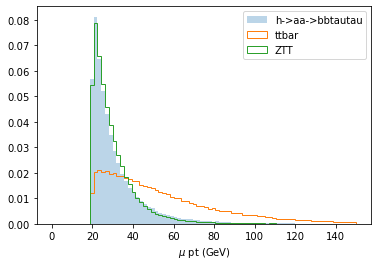

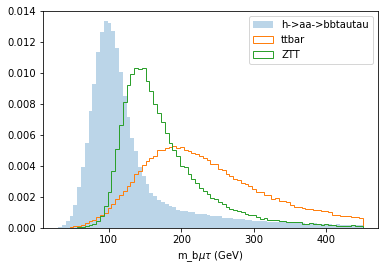

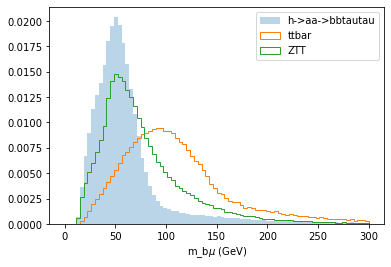

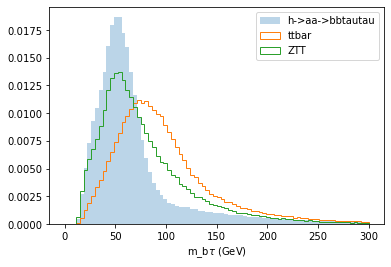

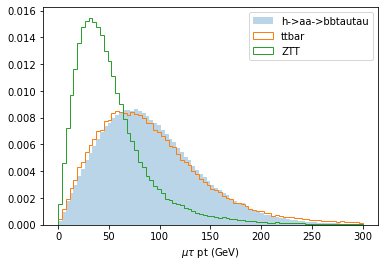

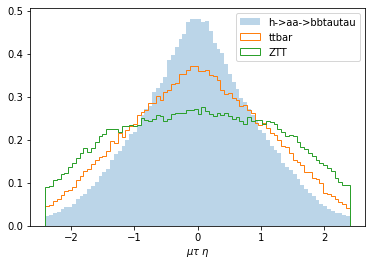

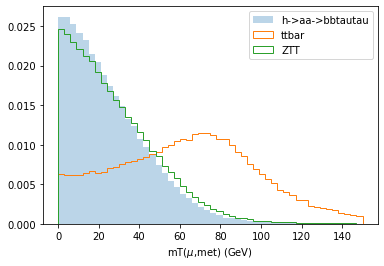

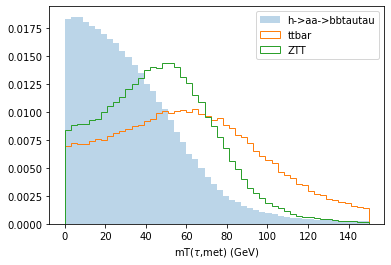

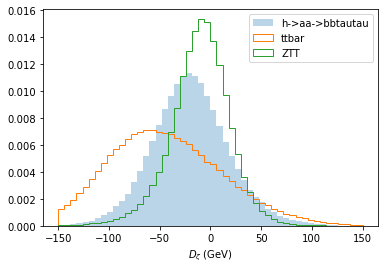

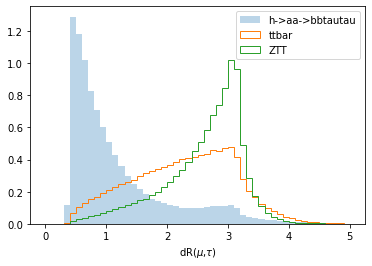

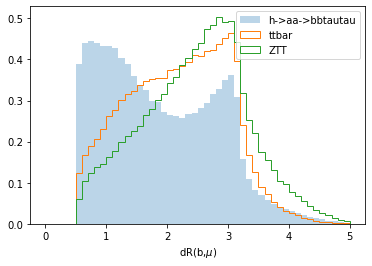

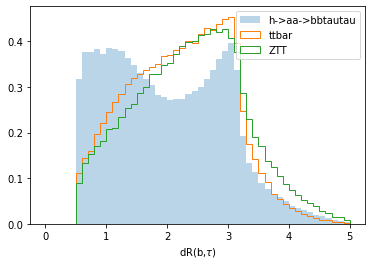

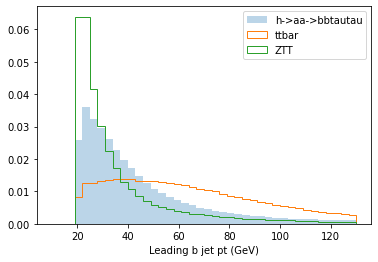

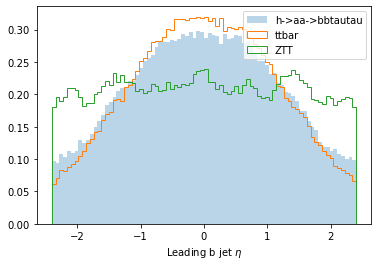

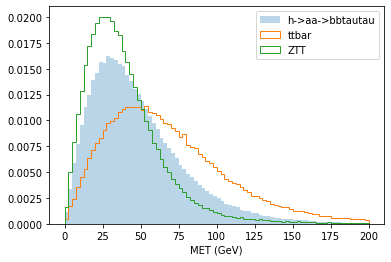

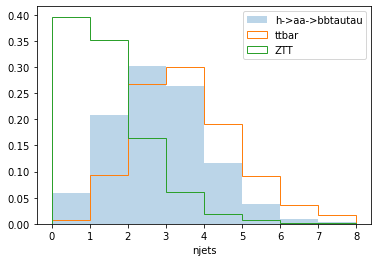

In [5]:
pyplot.hist(df_sig['pt_1'], density = 1, range = (0,150), bins = 80, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['pt_1'], density = 1, range = (0,150), bins = 80, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['pt_1'], density = 1, range = (0,150), bins = 80, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(df_sig['m_btt'], density = 1, range = (30,450), bins = 80, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['m_btt'], density = 1, range = (30,450), bins = 80, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['m_btt'], density = 1, range = (30,450), bins = 80, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\mu\\tau$ (GeV)')
pyplot.show()

pyplot.hist(df_sig['m_bmu'], density = 1, range = (0,300), bins = 80, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['m_bmu'], density = 1, range = (0,300), bins = 80, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['m_bmu'], density = 1, range = (0,300), bins = 80, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\mu$ (GeV)')
pyplot.show()

pyplot.hist(df_sig['m_btau'], density = 1, range = (0,300), bins = 80, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['m_btau'], density = 1, range = (0,300), bins = 80, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['m_btau'], density = 1, range = (0,300), bins = 80, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau$ (GeV)')
pyplot.show()

pyplot.hist(df_sig['tt_pt'], density = 1, range = (0,300), bins = 80, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['tt_pt'], density = 1, range = (0,300), bins = 80, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['tt_pt'], density = 1, range = (0,300), bins = 80, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(df_sig['tt_eta'], density = 1, range = (-2.4,2.4), bins = 80, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['tt_eta'], density = 1, range = (-2.4,2.4), bins = 80, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['tt_eta'], density = 1, range = (-2.4,2.4), bins = 80, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu\\tau$ $\eta$')
pyplot.show()

pyplot.hist(df_sig['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(df_sig['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau$,met) (GeV)')
pyplot.show()

pyplot.hist(df_sig['Dzeta'], density = 1, range = (-150,150), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['Dzeta'], density = 1, range = (-150,150), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['Dzeta'], density = 1, range = (-150,150), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(df_sig['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau$)')
pyplot.show()

pyplot.hist(df_sig['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b,$\mu$)')
pyplot.show()

pyplot.hist(df_sig['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b,$\\tau$)')
pyplot.show()

pyplot.hist(df_sig['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 40, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 40, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 40, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(df_sig['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 80, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 80, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 80, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet $\eta$')
pyplot.show()

pyplot.hist(df_sig['met'], density = 1, range = (0,200), bins = 80, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['met'], density = 1, range = (0,200), bins = 80, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['met'], density = 1, range = (0,200), bins = 80, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('MET (GeV)')
pyplot.show()

pyplot.hist(df_sig['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_TT['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(df_ZTT['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()


## Input data pre-processing

In [6]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

dataset_obs = df_obs.values
X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.9
val_ratio = 0.05
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=1)

# standardize feature variables (based on train and val sets)
scaler = StandardScaler().fit(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_obs = scaler.transform(X_obs)

# print input data shapes
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
print("\nX_obs.shape: " + str(X_obs.shape))
print("\nPartition of data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))

X_train.shape: (474339, 16)
Y_train.shape: (474339, 1)
X_val.shape: (26353, 16)
Y_val.shape: (26353, 1)
X_test.shape: (26353, 16)
Y_test.shape: (26353, 1)

X_obs.shape: (3702826, 16)

Partition of data set into train/val/test: 0.90/0.05/0.05

Total number of sig/bkg examples: 227045/300000 (43.08%/56.92%)

Number of sig/bkg examples in each set:
train : 204338/270001 (43.1%/56.9%)
val   : 11317/15036 (42.9%/57.1%)
test  : 11390/14963 (43.2%/56.8%)


## Neural network achitecture

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 16)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 20)                340       
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 20)                420       
_________________________________________________________________
Y_output (Dense)             (None, 1)                 21        
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________


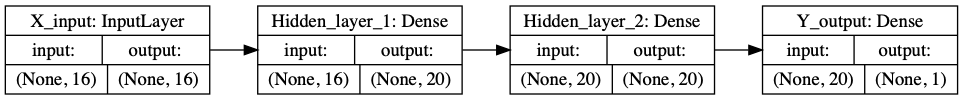

2021-01-08 20:26:54.426340: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-01-08 20:26:54.426988: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [7]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')


######## hidden layers ########
hidden_1 = Dense(
    units = 20,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

hidden_2 = Dense(
    units = 20,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(hidden_1)


######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(hidden_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

# plot model shape
plot_model(model, to_file = 'model_shape.png', rankdir = 'LR', show_shapes = True)

## Model training

In [8]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 80,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 474339 samples, validate on 26353 samples
Epoch 1/80
474339/474339 [==============================] - 6s 13us/step - loss: 0.2861 - accuracy: 0.8846 - val_loss: 0.2524 - val_accuracy: 0.9021
Epoch 2/80
474339/474339 [==============================] - 6s 13us/step - loss: 0.2466 - accuracy: 0.9029 - val_loss: 0.2427 - val_accuracy: 0.9052
Epoch 3/80
474339/474339 [==============================] - 5s 11us/step - loss: 0.2415 - accuracy: 0.9048 - val_loss: 0.2403 - val_accuracy: 0.9065
Epoch 4/80
474339/474339 [==============================] - 5s 11us/step - loss: 0.2391 - accuracy: 0.9058 - val_loss: 0.2390 - val_accuracy: 0.9065
Epoch 5/80
474339/474339 [==============================] - 5s 10us/step - loss: 0.2373 - accuracy: 0.9065 - val_loss: 0.2371 - val_accuracy: 0.9068
Epoch 6/80
474339/474339 [==============================] - 5s 10us/step - loss: 0.2360 - accuracy: 0.9068 - val_loss: 0.2353 - val_accuracy: 0.9065
Epoch 7/80
474339/474339 [=============================

474339/474339 [==============================] - 5s 11us/step - loss: 0.2261 - accuracy: 0.9104 - val_loss: 0.2287 - val_accuracy: 0.9097
Epoch 56/80
474339/474339 [==============================] - 5s 11us/step - loss: 0.2261 - accuracy: 0.9103 - val_loss: 0.2272 - val_accuracy: 0.9107
Epoch 57/80
474339/474339 [==============================] - 5s 11us/step - loss: 0.2259 - accuracy: 0.9103 - val_loss: 0.2288 - val_accuracy: 0.9096
Epoch 58/80
474339/474339 [==============================] - 5s 11us/step - loss: 0.2258 - accuracy: 0.9104 - val_loss: 0.2282 - val_accuracy: 0.9096
Epoch 59/80
474339/474339 [==============================] - 5s 11us/step - loss: 0.2258 - accuracy: 0.9104 - val_loss: 0.2277 - val_accuracy: 0.9099
Epoch 60/80
474339/474339 [==============================] - 5s 11us/step - loss: 0.2258 - accuracy: 0.9104 - val_loss: 0.2272 - val_accuracy: 0.9106
Epoch 61/80
474339/474339 [==============================] - 5s 10us/step - loss: 0.2257 - accuracy: 0.9103 - va

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

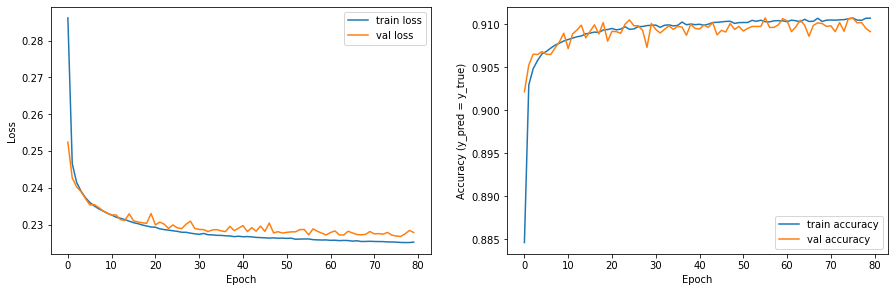

In [10]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [11]:
# count sig/bkg examples in the test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

## Test set performance plots

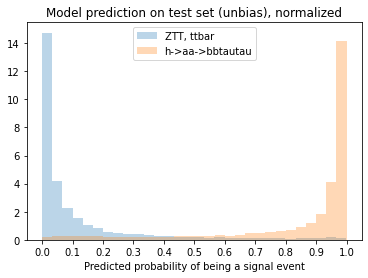

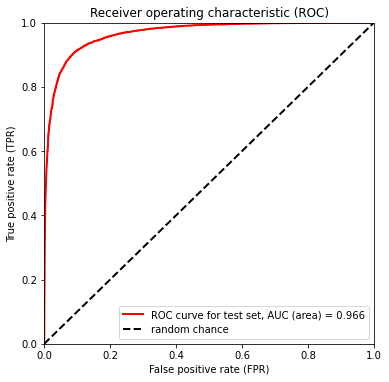

Test loss, test accuracy: [0.23144020299004436, 0.9090425968170166]


In [12]:
pyplot.hist(model.predict(X_test_bkg), density = 1, bins = 30, alpha = 0.3, label = 'ZTT, ttbar')
pyplot.hist(model.predict(X_test_sig), density = 1, bins = 30, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on test set (unbias), normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC (area) = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('False positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 512)
print("Test loss, test accuracy:", results)

## Prediction on the observed data set

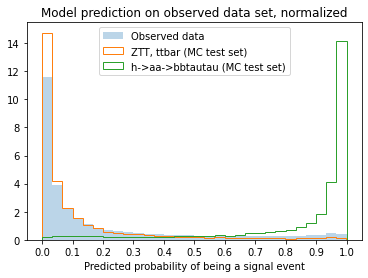

In [13]:
pyplot.hist(model.predict(X_obs), density = 1, bins = 30, alpha = 0.3, label = 'Observed data')
pyplot.hist(model.predict(X_test_bkg), density = 1, bins = 30, alpha = 1.0, label = 'ZTT, ttbar (MC test set)', histtype = 'step')
pyplot.hist(model.predict(X_test_sig), density = 1, bins = 30, alpha = 1.0, label = 'h->aa->bbtautau (MC test set)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on observed data set, normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()